In [14]:
import os
print(os.getcwd())

c:\Users\Computing Machine\Downloads\WINSTARS\test\task-2\code


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from torchvision.datasets.folder import default_loader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import List

MODEL_DIR = "cv_animal_model"
DATA_DIR = "../dataset/images" 
MODEL_NAME = "resnet18"
BATCH_SIZE = 32

In [16]:
# custom image loader from training script
def safe_image_loader(path):
    """Safely loads an image, converts it to RGB, returning None if corrupted."""
    try:
        img = Image.open(path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Warning: Failed to load image {path}. Skipping. Error: {e}")
        return None

In [17]:
# custom dataset wrapper to track file paths
class DatasetWithPaths(Subset):
    """
    Wrapper around a Subset (like one created by random_split) 
    that allows accessing file paths from the original ImageFolder.
    """
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.dataset = dataset
        # ImageFolder has .classes directly, not .dataset.classes
        self.classes = dataset.classes 

    def get_path(self, index_in_subset):
        # the index in the subset refers to an index in the 'indices' list
        original_index = self.indices[index_in_subset]
        # The original dataset (self.dataset) is the ImageFolder,
        # which stores paths in .imgs
        return self.dataset.imgs[original_index][0]

In [18]:
def load_data_and_model(data_dir: str, model_dir: str, model_name: str, train_split: float = 0.8):
    """Loads the model and prepares the validation data for evaluation."""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # data preparation, must match training script
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # load full dataset using the custom safe loader
    full_dataset = datasets.ImageFolder(data_dir, data_transforms, loader=safe_image_loader)
    
    if len(full_dataset) == 0:
        print("CRITICAL ERROR: Dataset is empty. Check DATA_DIR path.")
        return None, None, None, None, None # Ensure 5 Nones are returned on error

    # split data to identify validation indices
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    # data train-val split for unknown real-life data simulation
    train_dataset_subset, val_dataset_subset = random_split(full_dataset, [train_size, val_size])

    # wrap the validation subset to maintain access to file paths
    val_dataset = DatasetWithPaths(full_dataset, val_dataset_subset.indices)
    
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    class_names = val_dataset.classes
    num_classes = len(class_names)
    print(f"Loaded {len(val_dataset)} validation images for {num_classes} classes: {class_names}")

    # model loading
    model_path = os.path.join(model_dir, f"{model_name}_best.pth")
    if not os.path.exists(model_path):
        print(f"CRITICAL ERROR: Model file not found at {model_path}. Cannot proceed with EDA.")
        return None, None, None, None, None # ensure 5 Nones are returned on error

    if model_name == "resnet18":
        model = models.resnet18(weights=None) # load structure without pre-trained weights
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes) # re-define final layer
    else:
        raise NotImplementedError(f"Model {model_name} not implemented for EDA.")

    # load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval() # set model to evaluation mode
    
    return model, val_dataloader, class_names, device, val_dataset

In [19]:
def evaluate_model(model, dataloader, class_names: List[str], device, val_dataset):
    """Runs inference and generates the confusion matrix and misclassification report."""
    all_preds = []
    all_labels = []

    print("\nStarting inference on validation set...")
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # plotting the confusion matrix
    print("\n--- Generating Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    ax.set_title("Model Confusion Matrix ")
    plt.tight_layout()
    plt.show()

    # per-class accuracy and misclassification report
    total_samples = len(all_labels)
    correct_predictions = np.sum(np.array(all_preds) == np.array(all_labels))
    overall_accuracy = correct_predictions / total_samples
    print(f"\nOverall Validation Accuracy: {overall_accuracy:.4f} ({correct_predictions}/{total_samples})")

    print("\n--- Per-Class Accuracy ---")
    for i, class_name in enumerate(class_names):
        true_pos = cm[i, i]
        total_in_class = np.sum(cm[i, :])
        
        accuracy = true_pos / total_in_class if total_in_class > 0 else 0
        print(f"  {class_name}: Accuracy = {accuracy:.4f} ({true_pos}/{total_in_class})")
        
    # report top misclassified samples
    print("\n--- Top 5 Misclassified Samples for Inspection ---")
    misclassified_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]
    
    for i in range(min(5, len(misclassified_indices))):
        idx = misclassified_indices[i]
        predicted_class_idx = all_preds[idx]
        true_class_idx = all_labels[idx]
        
        # Use the wrapper to get the original file path
        file_path = val_dataset.get_path(idx)
        
        print(f"File: {os.path.basename(file_path)}")
        print(f"TRUE: {class_names[true_class_idx]}")
        print(f"PRED: {class_names[predicted_class_idx]}")

In [20]:
if __name__ == "__main__":
    # ensure matplotlib is set up for non-interactive environments
    try:
        plt.switch_backend('Agg')
    except ImportError:
        pass 
        
    model, dataloader, class_names, device, val_dataset = load_data_and_model(
        data_dir=DATA_DIR, 
        model_dir=MODEL_DIR, 
        model_name=MODEL_NAME
    )
    
    if model:
        evaluate_model(model, dataloader, class_names, device, val_dataset)
    else:
        # Added message if model loading failed
        print("Model loading failed. Please check the model path and file name.")


Using device: cpu
Loaded 3388 validation images for 9 classes: ['Cat', 'Cow', 'Deer', 'Dog', 'Goat', 'Hen', 'NightVision', 'Rabbit', 'Sheep']
CRITICAL ERROR: Model file not found at cv_animal_model\resnet18_best.pth. Cannot proceed with EDA.
Model loading failed. Please check the model path and file name.


In [21]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any

# configuration
BASE_DATA_DIR = "../dataset" 
LABELS_DIR = os.path.join(BASE_DATA_DIR, "images")
CLASS_NAMES_FILE = os.path.join(BASE_DATA_DIR, "cv_animal_model", "class_names.txt")
DEBUG_BOX_LIMIT = 10 
# define a limit for debug prints

In [22]:
def load_class_names(filepath: str) -> List[str]:
    """Reads class names from a text file, one name per line."""
    if not os.path.exists(filepath):
        print(f"CRITICAL ERROR: Class names file not found at {filepath}")
        return []
    with open(filepath, 'r') as f:
        # read each line, strip whitespace, and filter out empty lines
        return [line.strip() for line in f if line.strip()]

In [23]:
def parse_yolo_labels(labels_dir: str, class_names: List[str]) -> pd.DataFrame:
    """
    Scans the labels directory and parses all YOLO label files, 
    inferring the Class ID from the directory structure. (Logic for ID inference 
    is kept from the previous step to ensure all classes are counted).
    """
    data: List[Dict[str, Any]] = []
    txt_file_count = 0
    processed_roots = set()
    debug_box_count = 0
    
    # create a mapping for quick lookup: name -> id
    name_to_id = {name: i for i, name in enumerate(class_names)}
    
    abs_labels_dir = os.path.abspath(labels_dir)
    print(f"Checking for labels directory: {abs_labels_dir}")
    
    if not os.path.isdir(labels_dir):
        print(f"CRITICAL ERROR: Label directory not found at {abs_labels_dir}. Please correct LABELS_DIR.")
        # return empty dataframe if directory is missing
        return pd.DataFrame(data)
    
    # walk through all subdirectories starting from the labels directory
    for root, _, files in os.walk(labels_dir):
        inferred_class_id = -1
        inferred_class_name = None
        
        # infer class id from the directory path (e.g., /Cow/train/labels)
        for segment in root.split(os.sep):
            if segment in name_to_id:
                inferred_class_name = segment
                inferred_class_id = name_to_id[segment]
                # break once the class name is found in the path
                break
        
        # skip directories that don't correspond to a class name
        if inferred_class_id == -1:
             continue 
        
        for filename in files:
            if filename.endswith(".txt"):
                
                # exclude common non-label text files
                lower_filename = filename.lower()
                if "readme" in lower_filename or "names" in lower_filename or "classes" in lower_filename:
                    continue
                
                # print the start of processing for a new subdirectory
                if root not in processed_roots:
                    print(f"Found and starting to process label files in: {root}")
                    processed_roots.add(root)

                txt_file_count += 1
                label_path = os.path.join(root, filename)
                
                try:
                    boxes_in_file = 0
                    with open(label_path, 'r') as f:
                        # read line by line to process bounding boxes
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) == 5:
                                
                                # class_id is inherited from the directory structure
                                class_id_int = inferred_class_id
                                class_name = inferred_class_name

                                try:
                                    # parts[0] is typically the class id in a yolo file, 
                                    # but we use the inferred id for consistency with the directory
                                    original_file_id = int(float(parts[0]))
                                    cx, cy, w, h = map(float, parts[1:])
                                except ValueError as ve:
                                    # skip lines that don't contain valid float/int data
                                    continue
                                
                                
                                # skip invalid bounding boxes
                                if w == 0 or h == 0:
                                    continue
                                
                                # calculate metrics for analysis
                                aspect_ratio = w / h
                                normalized_area = w * h
                                
                                # infer the split (train/val/test) from the directory name
                                split = os.path.basename(root) 
                                if split not in ['train', 'val', 'test']:
                                    split = os.path.basename(os.path.dirname(root))
                                
                                # print debug information for the first few boxes
                                if debug_box_count < DEBUG_BOX_LIMIT: 
                                    print(f"DEBUG MAPPING: Overriding File ID {original_file_id} with Inferred ID {class_id_int} mapped to Name '{class_name}' (File: {filename})")
                                    debug_box_count += 1
                                    
                                data.append({
                                    'class_id': class_id_int,
                                    'class_name': class_name,
                                    'aspect_ratio': aspect_ratio,
                                    'normalized_area': normalized_area,
                                    'split': split
                                })
                                boxes_in_file += 1
                                
                        # warn if a text file was processed but yielded no boxes
                        if boxes_in_file == 0 and txt_file_count > 10:
                            print(f"WARNING: Label file {filename} contained 0 valid YOLO bounding boxes.")

                except Exception as e:
                    print(f"Error reading label file {label_path}: {e}")

    if txt_file_count == 0 and not data:
        print(f"\nDEBUG: No actual YOLO label files were found inside {abs_labels_dir} or its subdirectories.")

    df = pd.DataFrame(data)
    
    if not df.empty:
        # print a summary of the data found
        unique_ids = df['class_id'].unique()
        unique_names = df['class_name'].unique() 
        print(f"\nDEBUG: Successfully parsed data for Class IDs: {unique_ids}")
        print(f"DEBUG: Corresponding Class Names found: {unique_names}")
        
    return df

In [24]:
def plot_class_counts_histogram(df: pd.DataFrame):
    """Generates a histogram showing the total count of bounding boxes per class."""
    if df.empty:
        print("No label data found to plot class counts.")
        return

    # count the total number of bounding boxes for each class
    class_counts = df['class_name'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    
    # plotting the counts as a bar chart
    bars = class_counts.plot(kind='bar', color='darkgreen', alpha=0.7)
    
    plt.title("Ground Truth Object Count Distribution by Class", fontsize=14)
    plt.xlabel("Class Name")
    plt.ylabel("Total Bounding Box Count")
    plt.xticks(rotation=45, ha='right') # rotate labels for readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # add labels above the bars
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + (class_counts.max() * 0.01), # position text slightly above bar
            f'{int(bar.get_height())}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

    plt.tight_layout()
    # no plt.show() needed in jupyter
    plt.show()

In [25]:
def plot_aspect_ratio_histograms(df: pd.DataFrame, class_names: List[str]):
    """Generates histograms of aspect ratio for all classes."""
    if df.empty:
        print("No label data found to plot.")
        return

    # filter out extreme aspect ratios (e.g., > 10) for cleaner plots
    df_filtered = df[df['aspect_ratio'] < 10].copy()

    unique_classes = sorted(df_filtered['class_id'].unique())
    num_classes = len(unique_classes)
    
    # calculate the grid size
    cols = min(3, num_classes)
    rows = int(np.ceil(num_classes / cols))
    
    # create the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    print(f"\nGenerating {num_classes} Aspect Ratio Histograms...")
    
    # iterate through each unique class to create its histogram
    for i, class_id in enumerate(unique_classes):
        class_data = df_filtered[df_filtered['class_id'] == class_id]
        ax = axes_flat[i]
        
        # generate the histogram for aspect ratio
        ax.hist(class_data['aspect_ratio'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        
        class_name = class_data['class_name'].iloc[0]
        ax.set_title(f'Aspect Ratio: {class_name} (Boxes: {len(class_data)})')
        ax.set_xlabel('Aspect Ratio (Width / Height)')
        ax.set_ylabel('Frequency (Count)')
        ax.axvline(x=1.0, color='red', linestyle='--', linewidth=1, label='Square (Ratio=1)')
        ax.legend()
        ax.grid(axis='y', alpha=0.5)

    # remove unused subplots in the grid
    for j in range(num_classes, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.suptitle("YOLO Bounding Box Aspect Ratio Distribution by Class", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 

Loaded classes: ['Cat', 'Cow', 'Deer', 'Dog', 'Goat', 'Hen', 'NightVision', 'Rabbit', 'Sheep']
Checking for labels directory: c:\Users\Computing Machine\Downloads\WINSTARS\test\task-2\dataset\images
Found and starting to process label files in: ../dataset\images\Cat\train\labels
DEBUG MAPPING: Overriding File ID 0 with Inferred ID 0 mapped to Name 'Cat' (File: IMAGE-1-_jpg.rf.a85f233633aecd48ff0cf6c7d8254acc.txt)
DEBUG MAPPING: Overriding File ID 0 with Inferred ID 0 mapped to Name 'Cat' (File: IMAGE-1-_jpg.rf.c8254dacf34f5d852d2acbfa1766ba91.txt)
DEBUG MAPPING: Overriding File ID 0 with Inferred ID 0 mapped to Name 'Cat' (File: IMAGE-1-_jpg.rf.e4afca0721126aea010c7fbb795d498e.txt)
DEBUG MAPPING: Overriding File ID 0 with Inferred ID 0 mapped to Name 'Cat' (File: IMAGE-1-_png.rf.2f494e06a5866bb5f62bf1520348d24c.txt)
DEBUG MAPPING: Overriding File ID 0 with Inferred ID 0 mapped to Name 'Cat' (File: IMAGE-1-_png.rf.4cc7eada3eb323345bf53f305ebef9f9.txt)
DEBUG MAPPING: Overriding File ID 0

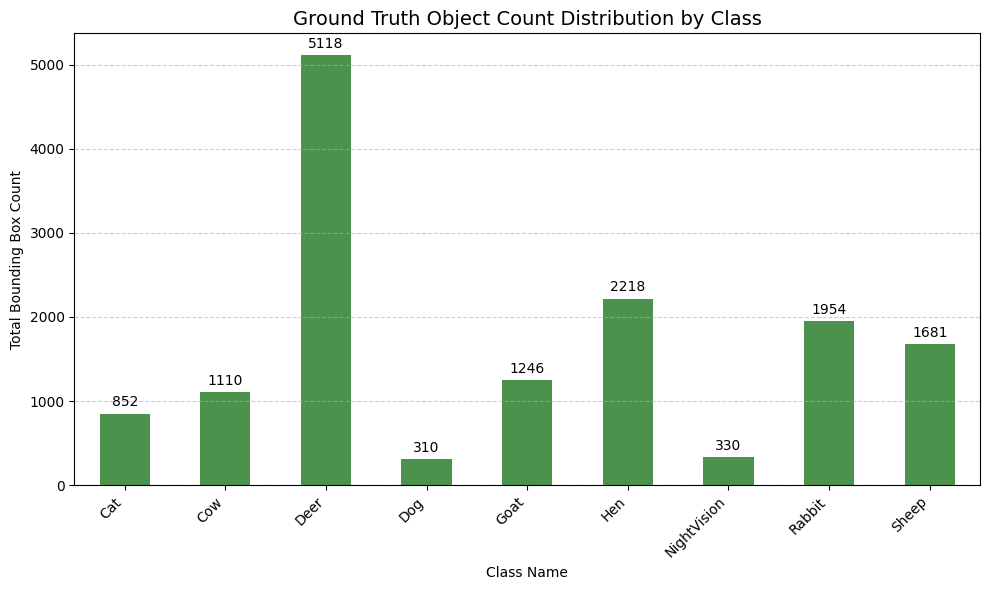


Generating 9 Aspect Ratio Histograms...

--- Aspect Ratio Complete Summary (Mean, Median, Std Dev, Count) ---
               mean  median     std  count
class_name                                
Deer        1.07529 0.93066 0.70185   5118
Dog         1.06588 0.83911 0.70634    310
Sheep       1.06236 0.80337 0.95743   1681
NightVision 1.04236 1.00000 0.32331    330
Cow         1.03225 0.97487 0.45232   1110
Cat         1.00256 0.95624 0.44093    852
Rabbit      0.98725 0.90413 0.44430   1954
Goat        0.98453 0.66379 0.78750   1246
Hen         0.96719 0.61740 0.74962   2218


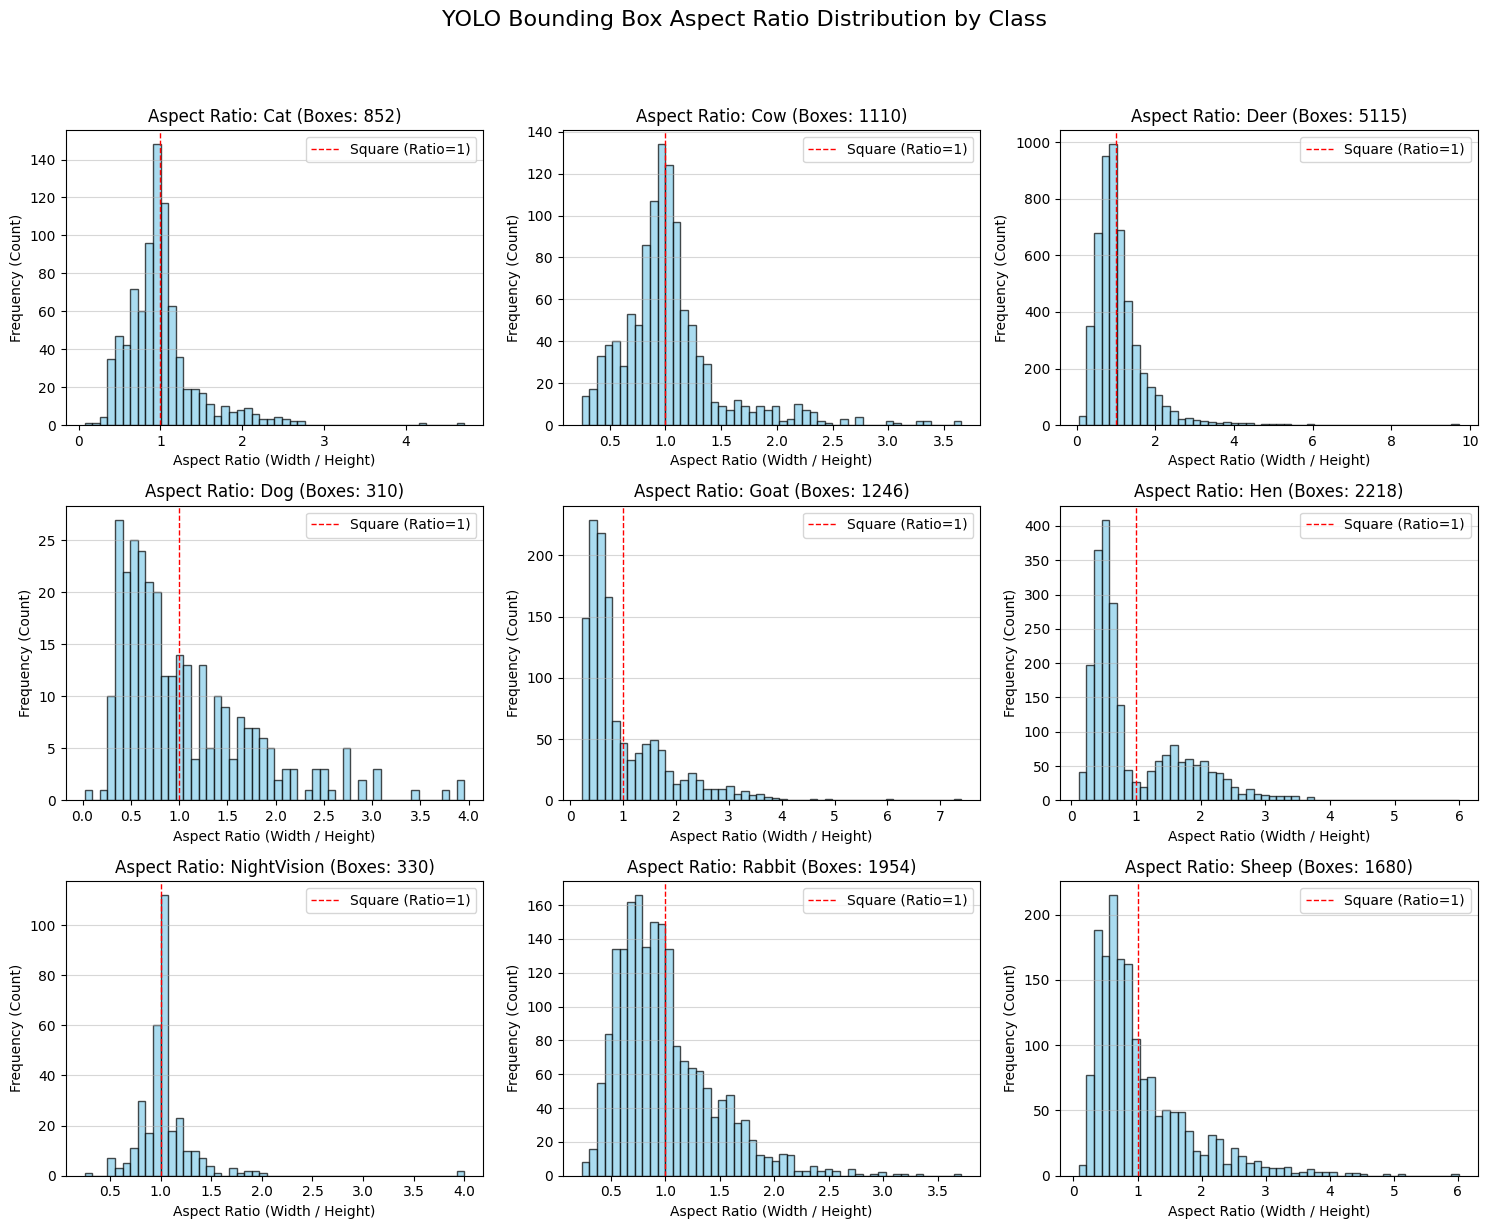

In [26]:
if __name__ == "__main__":
    
    # load class names
    class_names = load_class_names(CLASS_NAMES_FILE)
    if not class_names:
        print("Please ensure your class names are available in the specified file.")
    else:
        print(f"Loaded classes: {class_names}")

    # parse label data
    df_labels = parse_yolo_labels(LABELS_DIR, class_names)
    print(f"\nTotal bounding boxes parsed: {len(df_labels)}")

    if not df_labels.empty:
        
        # visualize the overall balance of the dataset
        plot_class_counts_histogram(df_labels)

        # generate and show aspect ratio plot
        # visualize the shape distribution of bounding boxes
        plot_aspect_ratio_histograms(df_labels, class_names)
        
        # calculate and display the complete summary table
        # group by class and aggregate the aspect ratio statistics
        stats_summary = df_labels.groupby('class_name')['aspect_ratio'].agg(['mean', 'median', 'std', 'count'])
        
        pd.set_option('display.float_format', '{:.5f}'.format) 
        
        print("\n--- Aspect Ratio Complete Summary (Mean, Median, Std Dev, Count) ---")
        print(stats_summary.sort_values('mean', ascending=False))
        # print the summary, sorted by mean aspect ratio